In [1]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold,StratifiedKFold
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import random
import re
import torch

In [5]:
def fetch(target):
    fname_human = f'{target}_HUMAN.csv'
    df_human = pd.read_csv(fname_human, sep=';')

    fname_rat = f'{target}_RAT.csv'
    df_rat = pd.read_csv(fname_rat, sep=';')

    fname_mouse = f'{target}_MOUSE.csv'
    df_mouse = pd.read_csv(fname_mouse, sep=';')

    df = pd.concat([df_human, df_rat, df_mouse])

    mask = df['Standard Type'] == 'IC50'

    td = 100
    pmask = (df[mask]['Standard Value'] < td) & (df[mask]['Standard Value'] > 0)
    nmask = df[mask]['Standard Value'] > td

    len_p = sum(pmask)
    len_n = sum(nmask)

    print(f'靶点：{target}, 正样本数量：', len_p)
    print(f'靶点：{target}, 负样本数量：', len_n)

    df_p = df[mask][pmask]
    df_n = df[mask][nmask]

    return df_p, df_n, len_p

In [6]:
df_ep2_p, df_ep2_n, len_ep2_p = fetch('EP2')

靶点：EP2, 正样本数量： 37
靶点：EP2, 负样本数量： 260


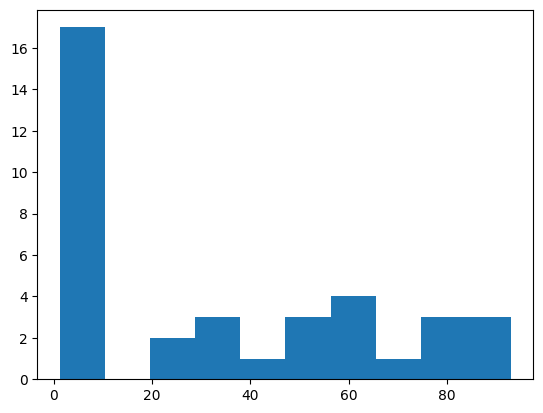

In [7]:
n, bins, patches = plt.hist(df_ep2_p['Standard Value'], 10, density=False)
plt.show()

In [10]:
outputs = []
data_mix = []

for i in range(len_ep2_p):
    index = df_ep2_p.index[i]
    smiles = df_ep2_p['Smiles'][index]
    ic50 = df_ep2_p['Standard Value'][index]

    try:
        m=Chem.MolFromSmiles(smiles)
        # print(smiles)
    except Exception as e:              # 不能解析的话跳过
        continue

    desc = 'It can bind to Prostanoid EP2 receptor.'
    outputs.append(['None', 'None', desc, smiles])
    data_mix.append([smiles,ic50,1])

for i in range(len_ep2_p):
    index = df_ep2_n.index[i]
    smiles = df_ep2_n['Smiles'][index]
    ic50 = df_ep2_n['Standard Value'][index]

    try:
        m=Chem.MolFromSmiles(smiles)
        # print(smiles)
    except Exception as e:              # 不能解析的话跳过
        continue

    desc = 'It can not bind to Prostanoid EP2 receptor.'
    outputs.append(['None', 'None', desc, smiles])
    data_mix.append([smiles,ic50,0])

len(outputs)

66

In [11]:
outputs = pd.DataFrame(data=outputs, columns=['cid','iupac','desc','smiles'])
outputs.to_csv(f'../data/train/EP2.csv', index=False)
print('Saved.')

Saved.


# 分类器

In [12]:
df_mix = pd.DataFrame(data=data_mix, columns=['smiles','IC50','label'])
df_mix = df_mix.sample(frac=1)
df_mix

,smiles,IC50,label
48,COc1cc(-c2csc3ccccc23)cc2c1OCCN(Cc1cccnc1)C2=O,30000.0,0
9,CCCCC[C@H](O)/C=C/[C@H]1[C@H](O)CC(=O)[C@@H]1C...,37.7,1
56,O=C(O)CN1C(=O)[C@@]2(CC(=O)N(Cc3cccc(Cl)c3)C2=...,30000.0,0
18,O=c1cc(CN2CCOc3c(Cl)cc(-n4ccc5cc(F)ccc54)cc3C2...,50.0,1
21,O=c1cc(CN2CCOc3c(Cl)cc(-c4csc5ccccc45)cc3C2)cc...,20.0,1
...,...,...,...
44,O=C(O)Cn1c2c(c3cc(F)ccc31)CN(C(=O)c1cccc3ccccc...,2600.0,0
1,O=C(O)CNc1cccc(CN(Cc2ccc(-n3cccn3)cc2)S(=O)(=O...,10.0,1
7,COc1cc(-c2csc3ccccc23)cc2c1OCCN(Cc1cncnc1)C2,20.0,1
19,COc1cc(-n2ccc3cc(F)ccc32)cc2c1OCCN(Cc1cccnc1)C2,40.0,1


In [13]:
smiles_list = df_mix['smiles'].values
y = df_mix['label'].values
ic50s = df_mix['IC50'].values
sum(y==0)

31

In [14]:
x = []
for smiles in smiles_list:
    mol=Chem.MolFromSmiles(smiles)
    fp = MACCSkeys.GenMACCSKeys(mol)
    # fp_bits = fp.ToBitString()
    fp_bits = fp.ToList()
    x.append(fp_bits)
x = np.array(x)
x.shape

(66, 167)

In [15]:
sfolder = StratifiedKFold(n_splits=5,random_state=0,shuffle=True)

In [16]:
f1_list = []
precision_list =  []
regr_list = []
for train, test in sfolder.split(x,y,ic50s):
    # print(sum(y[test]==0))
    # print(sum(y[test]==1))
    regr = make_pipeline(SVC(kernel='rbf', probability = True))
    regr.fit(x[train], y[train])
    pred = regr.predict(x[test])

    # for i in range(len(pred)):
    #     if pred[i] != y[test][i]:
    #         print(f"预测值: {pred[i]}, 实际值: {y[test][i]}, IC50: {ic50s[test][i]}")

    # print(pred)
    # print(y[test])
    f1 = f1_score(y[test].reshape(-1,1), pred.reshape(-1,1), average='micro')
    p_score = precision_score(y[test], pred, average='micro')
    f1_list.append(f1)
    precision_list.append(p_score)
    print(f"f1: {f1}; precision: {p_score}.")

    regr_list.append(regr)

f1_ts = torch.Tensor(f1_list)
precision_ts = torch.Tensor(precision_list)

print(f"F1 mean: {f1_ts.mean()}, std: {f1_ts.std()}.")
print(f"Precision mean: {precision_ts.mean()}, std: {precision_ts.std()}.")

f1: 0.8571428571428571; precision: 0.8571428571428571.
f1: 0.8461538461538461; precision: 0.8461538461538461.
f1: 0.8461538461538461; precision: 0.8461538461538461.
f1: 0.8461538461538461; precision: 0.8461538461538461.
f1: 1.0; precision: 1.0.
F1 mean: 0.8791208267211914, std: 0.06774081289768219.
Precision mean: 0.8791208267211914, std: 0.06774081289768219.


In [17]:
import joblib
joblib.dump(regr_list[4], "SVC_EP2.m")

['SVC_EP2.m']